#Tercer intento#



*   Solo con los datos de Madrid de Idealista2018
*   Madrid_Sale.csv y Madrid_Polygons.rda bajados de https://github.com/paezha/idealista18/tree/e2cfe3f621e1c37f226ce956f61b7306c42d5721/data


*   archivo Madrid_Polygons.rda transformado en csv con Notebook en R Script R rda a csv.ipyn https://colab.research.google.com/drive/1I06zwKUreseL1p87dHq0TzMheUHiEmVc


*   Exploración de datos (EDA) copiado de https://github.com/enricobonii/Idealista-Project/blob/main/IdealistaProject%20v4.ipynb
*Agregar la Columna neighbourhood a df_Madrid: de la latitud y longitud de cada casa se busca el barrio al que corresponde en Madrid_Polygons.csv

* la variable que vamos intentar predecir va a ser la diferencia en % entre el precio del piso y el precio medio por barrio - usaremos solo los datos del cuarto trimestre, quitando los que la diferencia sea mayor del 100%

* lo siguiente, Multivariate Analysis etc. copiado de https://github.com/enricobonii/Idealista-Project/blob/main/IdealistaProject%20v4.ipynb no se ha tocado de momento





In [1]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# Ruta al archivo CSV en Google Drive
file_path = '/content/drive/My Drive/Idealista_2024/datos_2018/'

Mounted at /content/drive


In [ ]:
from getpass import getpass
import os

# Solicita el token personal de GitHub
token = getpass('GitHub Token: ')

# Define la URL del repositorio y la ruta de clonación
repo_url = "https://github.com/edouardor/Idealista_2024.git"
destino = "/content/drive/MyDrive/Idealista_2024"

# Clona el repositorio en la carpeta de Google Drive
os.system(f'git clone https://{token}@github.com/edouardor/Idealista_2024.git {destino}')


In [ ]:
%cd /content/drive/MyDrive/Idealista_2024

In [ ]:
!ls -a


In [ ]:
!git config --global user.email "edouardo@hotmail.es"
!git config --global user.name "edouardor"

In [ ]:
# Agregar los archivos modificados
!git add .

# Hacer un commit
!git commit -m "Actualización desde Google Colab"

# Hacer push de los cambios
!git push


**Para ver las diferencias con el notebook anterior:**

*descomentar las lineas siguientes*

In [ ]:
#!pip install nbdime
#!nbdiff Notebooks/"Idealista Madrid github.ipynb"


In [ ]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import radians, cos, sin, asin, sqrt
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

pd.set_option('display.max_columns', None)

## Initializing Datasets

###Solo Madrid


In [ ]:

df= pd.read_csv(file_path+'gdf_Madrid_with_metro_count.csv')


In [ ]:
gdf = pd.read_csv(file_path+'Madrid_Polygons_with_mean_unitprice.csv')

*para poner luego los clusters definidos para cada barrio*

In [ ]:
df.head(3)

## Exploratory Data Analysis

In [ ]:
print(df.dtypes)

From here we can observe that the formatted variable types make sense with the expected and are homogeneous among the different datasets.

In [ ]:
df.describe(include='all')

In [ ]:
# prompt: drop observertions where df[df['ROOMNUMBER']>20]

df = df[df['ROOMNUMBER'] <= 20]

In [ ]:
# dime cuales son los valores medios de UNITPRICE para cada periodo, y la diferencia en % con el primer periodo - con dos decimales es suficiente - pon tambien cuantos datos hay en df para cada periodo


# Group data by 'PERIOD' and calculate the mean of 'UNITPRICE'
mean_unitprice_by_period = df.groupby('PERIOD')['UNITPRICE'].agg(['mean', 'count'])

# Calculate the percentage difference from the first period
first_period_mean = mean_unitprice_by_period['mean'].iloc[0]
mean_unitprice_by_period['pct_change'] = ((mean_unitprice_by_period['mean'] - first_period_mean) / first_period_mean) * 100

# Format the output
mean_unitprice_by_period['pct_change'] = mean_unitprice_by_period['pct_change'].round(2)
mean_unitprice_by_period = mean_unitprice_by_period.rename(columns={'mean':'mean_unitprice', 'count':'n_datapoints'})

mean_unitprice_by_period

In [ ]:
# vamos a usar solo los del 4º periodo, para evitar las diferencias de precio debido a la inflacíon
df = df[df['PERIOD'] == 4]

In [ ]:
# Agrupar por barrio y calcular el precio medio del m²
precio_medio_barrio = df.groupby('neighbourhood')['UNITPRICE'].mean().reset_index()

# Renombrar la columna para mayor claridad
precio_medio_barrio.rename(columns={'UNITPRICE': 'Precio_medio_m2'}, inplace=True)

print(precio_medio_barrio.head())

In [ ]:
# prompt: quiero poner en el dataframe una columna con el precio medio del m2 de cada barrio

# Fusionar el DataFrame original con el DataFrame de precios medios por barrio
df = pd.merge(df, precio_medio_barrio, on='neighbourhood', how='left')


In [ ]:
# prompt: pon una columna con (UNITPRICE - Precio_medio_m2)/Precio_medio_m2

# Calculate the new column
df['diferencia_precio_m2'] = (df['UNITPRICE'] - df['Precio_medio_m2']) / df['Precio_medio_m2']

In [ ]:
# prompt: haz un histograma con esta columna

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and it has a column named 'diferencia_precio_m2'
plt.figure(figsize=(10, 6))
sns.histplot(df['diferencia_precio_m2'], kde=True)
plt.title('Histograma de la Diferencia del Precio del m²')
plt.xlabel('Diferencia del Precio del m²')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# prompt: dime cuantos valores hay superiores a 1

# Assuming 'df' is your DataFrame and it has a column named 'diferencia_precio_m2'
count_greater_than_1 = len(df[df['diferencia_precio_m2'] > 1])
print(f"Hay {count_greater_than_1} valores superiores a 1 en la columna 'diferencia_precio_m2'.")

In [ ]:
# prompt: quita los valores superiores a 1 en el df

# Assuming 'df' is your DataFrame and it has a column named 'diferencia_precio_m2'
df = df[df['diferencia_precio_m2'] <= 1]

In [ ]:
# prompt: cuenta los valores diferentes de las columnas 'HASTERRACE', 'HASLIFT', 'HASAIRCONDITIONING', 'AMENITYID',
#        'HASPARKINGSPACE','HASBOXROOM', 'HASWARDROBE',
#        'HASSWIMMINGPOOL', 'HASDOORMAN', 'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO',
#        'ISINTOPFLOOR', 'FLOORCLEAN' , y dime cuantos hay de cada uno

# Define the columns to analyze
columns_to_analyze = ['AMENITYID']

# Loop through each column and count unique values
for column in columns_to_analyze:
  print(f"Column: {column}")
  value_counts = df[column].value_counts()
  print(value_counts)
  print("-" * 20)

In [ ]:
df.columns

In [ ]:

madrid = df.drop(columns=['ASSETID', 'PERIOD', 'PRICE', 'UNITPRICE', 'ADTYPOLOGYID',
       'ADOPERATIONID','AMENITYID','HASNORTHORIENTATION', 'HASSOUTHORIENTATION',
       'HASEASTORIENTATION', 'HASWESTORIENTATION','FLATLOCATIONID',
       'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT', 'CADASTRALQUALITYID','DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO', 'DISTANCE_TO_STREET',
       'LONGITUDE', 'LATITUDE', 'CITYNAME', 'ADTYPOLOGY', 'ADOPERATION',
       'neighbourhood', 'metros_within_500m'])

In [ ]:
madrid.columns

In [ ]:
madrid.CADCONSTRUCTIONYEAR = madrid.CADCONSTRUCTIONYEAR - 2018

In [ ]:
# prompt: enseñame las correlaciones entre las variables

# Calculate the correlation matrix
correlation_matrix = madrid.corr()


# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Madrid Dataset')
plt.show()

Importar Librerías Necesarias:

## Multivariate Analysis

In [ ]:
print(madrid.dtypes)

In [ ]:
# print list of columns from correlation matrix in decreasing order of correlation with Price
correlation_matrix['diferencia_precio_m2'].sort_values(ascending=False)

As per the above table, in Madrid,, we can see that the columns CONSTRUCTEDAREA, BATHNUMBER, ROOMNUMBER, HASDOORMAN, HASLIFT, HASPARKINGSPACE, metro_within_500 m, FloorClean are some of the columns that have a higher correlation with the PRICE of the asset listed.

**Analysing the pricing of assets based on location**

## ML Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
import statsmodels.api as sm

X = madrid.drop(['diferencia_precio_m2'], axis=1)
y = madrid['diferencia_precio_m2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
y_train.shape

In [ ]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model_sm = sm.OLS(y_train, X_train_sm).fit()

y_pred = model_sm.predict(X_test_sm)

mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'MAE: {mae}')
print(f'MDAE: {mdae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

print(model_sm.summary())

In [71]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np


# 3. Entrenar el modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# 4. Realizar predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test)

# 5. Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')


RMSE: 0.2118810220974372


In [74]:
precios_pred = (1 + y_pred)  * df['Precio_medio_m2']


ValueError: operands could not be broadcast together with shapes (6263,) (31312,) 

In [ ]:
from sklearn.metrics import mean_absolute_error

# Calcular MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE en precio original: {mae}')

# Calcular MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE en precio original: {mape}%')


MAE en precio original: 64959.35576082519
MAPE en precio original: 16.960346021035505%


In [ ]:
from sklearn.model_selection import cross_val_score

# Calcular RMSE con validación cruzada
scores = cross_val_score(modelo, X, y, scoring='neg_mean_squared_error', cv=5)
rmse_cv = np.sqrt(-scores.mean())
print(f'RMSE CV en log(precio): {rmse_cv}')


RMSE CV en log(precio): 0.22049037477026226


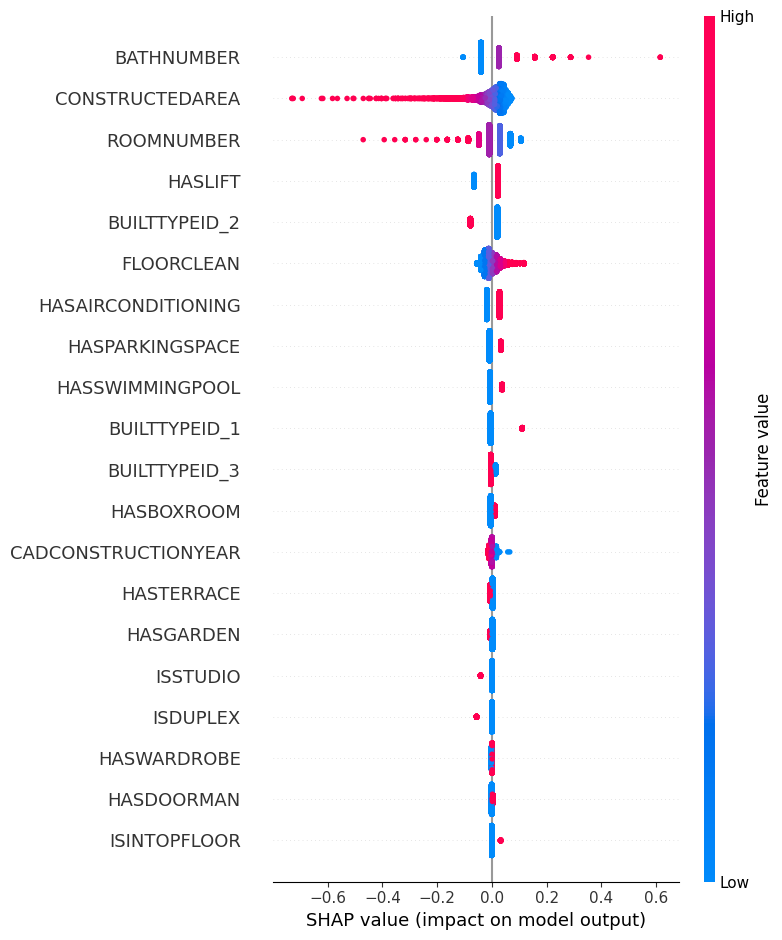

In [70]:
import shap

# Crear un objeto explainer
explainer = shap.Explainer(modelo, X_train)
shap_values = explainer(X_test)

# Visualizar los valores SHAP
shap.summary_plot(shap_values, X_test)


*Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}*

Fitting 5 folds for each of 1 candidates, totalling 5 fits
MAE: 0.14444562874066014
MDAE: 0.10358585942424448
RMSE: 0.2047934092678557
MAPE: 1.1560606875204664%
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
                Feature  Importance
0        Log_Superficie    0.668474
15     Cluster_Ordenado    0.214294
13   DISTANCE_TO_STREET    0.023897
4               HASLIFT    0.022622
12    DISTANCE_TO_METRO    0.019452
11  CADCONSTRUCTIONYEAR    0.016108
2            BATHNUMBER    0.010915
1            ROOMNUMBER    0.005617
14   metros_within_500m    0.003909
5    HASAIRCONDITIONING    0.003824
6       HASSWIMMINGPOOL    0.003702
9       HASPARKINGSPACE    0.002768
3            HASTERRACE    0.002011
10            HASGARDEN    0.001326
8          ISINTOPFLOOR    0.000647
7              ISSTUDIO    0.000434


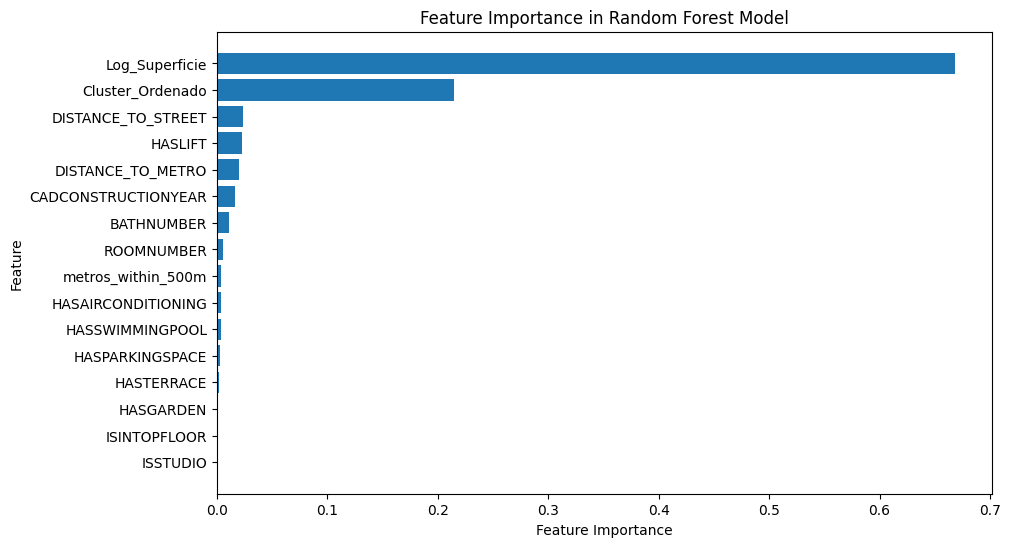

In [ ]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
#import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [300], #[100, 200, 300]
    'max_depth': [None], #[10, 20, None]
    'min_samples_split': [2], #[2, 5, 10]
    'min_samples_leaf': [1], #[1, 2, 4]
    'bootstrap': [True] #[True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

y_pred_log = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_log)
mdae = median_absolute_error(y_test, y_pred_log)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_log))
mape = np.mean(np.abs((y_test - y_pred_log) / y_test)) * 100

print(f'MAE: {mae}')
print(f'MDAE: {mdae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

print(f'Best parameters found: {grid_search.best_params_}')

feature_importances = best_rf.feature_importances_
features = X.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Convertir predicciones logarítmicas a precios originales
y_pred = np.exp(y_pred_log)

# Convertir valores reales logarítmicos a precios originales
y_true = np.exp(y_test)

# Calcular RMSE en la escala original
rmse_original = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE en precio original: {rmse_original}')



RMSE en precio original: 114970.60747677916


In [ ]:
# Calcular MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE en precio original: {mae}')

# Calcular MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE en precio original: {mape}%')

MAE en precio original: 58272.48349981926
MAPE en precio original: 15.12677647407458%


*Best parameters found: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 1.0}*


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [300], #[100, 200, 300],
    'max_depth': [10],#[3, 5, 7, 10],
    'learning_rate': [0.05], #[0.01, 0.05, 0.1, 0.2],
    'subsample': [1], #[0.6, 0.8, 1.0],
    'colsample_bytree':[0.6], #[0.6, 0.8, 1.0],
    'reg_alpha': [0.1], #[0, 0.1, 0.5, 1],
    'reg_lambda': [0] #[0, 0.1, 0.5, 1]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

y_pred_log = best_xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_log)
mdae = median_absolute_error(y_test, y_pred_log)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_log))
mape = np.mean(np.abs((y_test - y_pred_log) / y_test)) * 100

print(f'MAE: {mae}')
print(f'MDAE: {mdae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

#Convertir predicciones logarítmicas a precios originales
y_pred = np.exp(y_pred_log)

# Convertir valores reales logarítmicos a precios originales
y_true = np.exp(y_test)

# Calcular RMSE en la escala original
rmse_original = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE en precio original: {rmse_original}')

# Calcular MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE en precio original: {mae}')

# Calcular MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE en precio original: {mape}%')

print(f'Best parameters found: {grid_search.best_params_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
MAE: 0.13695258936614077
MDAE: 0.10204509554911212
RMSE: 0.18805068017067247
MAPE: 1.0920569204751316%
RMSE en precio original: 97727.78940842774
MAE en precio original: 52927.03363930283
MAPE en precio original: 13.874653106144763%
Best parameters found: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 1}


In [ ]:
from sklearn.model_selection import cross_val_score

modelo = XGBRegressor(random_state=42, **grid_search.best_params_)
scores = cross_val_score(modelo, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_cv = np.sqrt(-scores.mean())
print(f'RMSE CV en log(precio): {rmse_cv}')


RMSE CV en log(precio): 0.18715205867103274


In [ ]:
# Solo si deseas verificar (no recomendado para evaluar rendimiento)
y_pred_all_log = best_xgb.predict(X)
y_pred_all = np.exp(y_pred_all_log)
y_true_all = np.exp(y)

mape_all = np.mean(np.abs((y_true_all - y_pred_all) / y_true_all)) * 100
print(f'MAPE en todo el conjunto: {mape_all}%')


MAPE en todo el conjunto: 8.617381155881192%


In [ ]:
# Suponiendo que 'df_Madrid' ya contiene la columna 'Cluster_Ordenado'

# Definir los grupos basados en 'Cluster_Ordenado'
def asignar_grupo(cluster):
    if cluster <= 6:
        return 'Normal'
    else:
        return 'De Lujo'

df_Madrid_abridged['Grupo'] = df_Madrid_abridged['Cluster_Ordenado'].apply(asignar_grupo)

# Verificar la distribución de los grupos
print(df_Madrid_abridged['Grupo'].value_counts())


Grupo
Normal    31394
Name: count, dtype: int64


In [ ]:
PRICE_pred_log = best_xgb.predict(X)

In [ ]:
PRICE_pred = np.exp(PRICE_pred_log)

In [ ]:
df_Madrid_abridged['PRICE_pred'] = PRICE_pred

In [ ]:
# Suponiendo que 'df_Madrid' tiene las siguientes columnas:
# - 'Precio_m2': Precio real.
# - 'Precio_Predicho': Precio predicho por el modelo.

# Asegúrate de tener las predicciones en la escala original
# Si tienes predicciones en log, conviértelas:
# df_Madrid['Precio_Predicho'] = np.exp(df_Madrid['Log_Precio_Predicho'])

# Calcular el MAPE para cada piso
df_Madrid_abridged['MAPE'] = np.abs((df_Madrid_abridged['PRICE'] - df_Madrid_abridged['PRICE_pred']) / df_Madrid_abridged['PRICE']) * 100

# Verificar algunos valores
print(df_Madrid_abridged[['PRICE', 'PRICE_pred', 'MAPE']].head())


     PRICE     PRICE_pred       MAPE
0   166000  176642.375000   6.411069
3   125000  117490.101562   6.007919
13   96000   88075.031250   8.255176
18  301000  287353.406250   4.533752
19   90000  102462.234375  13.846927


In [ ]:
# Calcular el MAPE medio por Cluster Geográfico
mape_por_cluster_geografico = df_Madrid_abridged.groupby('Cluster_Geografico')['MAPE'].mean().reset_index()

print(mape_por_cluster_geografico)


   Cluster_Geografico      MAPE
0                   0  9.290466
1                   1  8.941783
2                   2  8.399518
3                   3  7.846164
4                   4  8.308608
5                   5  7.839241
6                   6  8.212691
7                   7  8.791329
8                   8  8.203398


In [ ]:
# Calcular el MAPE medio por Cluster Ordenado
mape_por_cluster_ordenado = df_Madrid_abridged.groupby('Cluster_Ordenado')['MAPE'].mean().reset_index()

print(mape_por_cluster_ordenado)

   Cluster_Ordenado      MAPE
0                 0  8.980637
1                 1  8.922337
2                 2  8.302031
3                 3  8.378580
4                 4  8.547853
5                 5  8.357779
